/tmp/ipykernel_16106/103452311.py:47: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab20', len(teams))


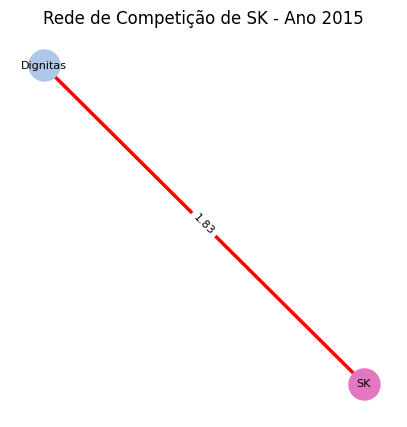

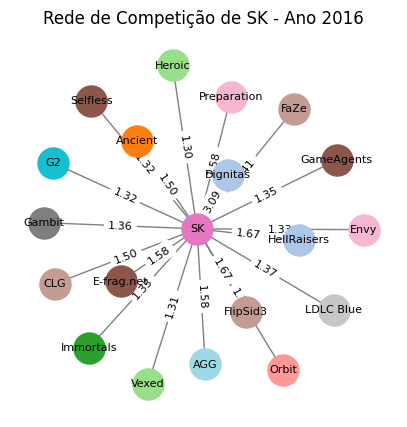

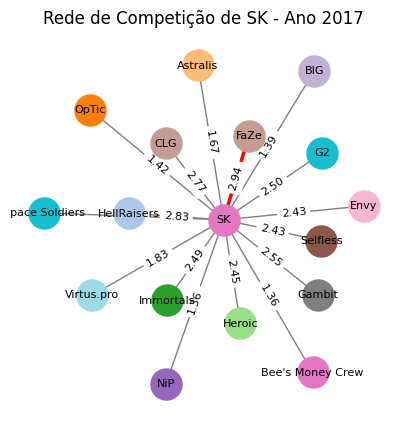

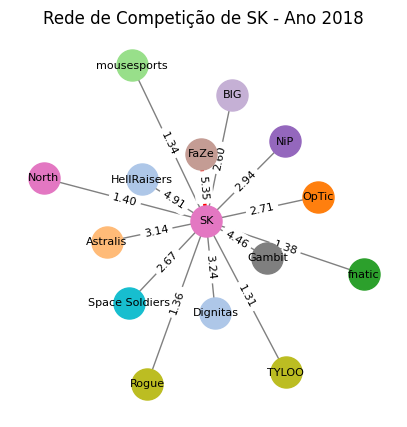

In [13]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

team_to_analyze = 'SK'  # Substitua pelo nome da equipe desejada
df = pd.read_csv('../db/results.csv')

# Conversões necessárias
df['result_1'] = pd.to_numeric(df['result_1'], errors='coerce')
df['result_2'] = pd.to_numeric(df['result_2'], errors='coerce')
df['date'] = pd.to_datetime(df['date'])
df['year'] = df['date'].dt.year

# Suponha que você tenha colunas para o ranking das equipes
df['rank_1'] = pd.to_numeric(df['rank_1'], errors='coerce')
df['rank_2'] = pd.to_numeric(df['rank_2'], errors='coerce')

df_filtered = df[(df['team_1'] == team_to_analyze) | (df['team_2'] == team_to_analyze)]

minRivalry = 1.3 # Limiar de rivalidade

def calcular_peso_consistente(row, ano, grafos_anteriores):
    peso_atual = 1 + (1 / (1 + abs(row['result_1'] - row['result_2']))) + (1 / (1 + abs(row['rank_1'] - row['rank_2'])))
    if row['map_winner'] in ['1', '2']:
        peso_atual += 0.5

    peso_consistente = 0
    for ano_anterior, grafo in grafos_anteriores.items():
        if grafo.has_edge(row['team_1'], row['team_2']):
            peso_consistente += grafo.edges[row['team_1'], row['team_2']]['weight'] / (ano - ano_anterior)
    
    return peso_atual + peso_consistente

graphs_by_year = {}
for year, group in df_filtered.groupby('year'):
    G = nx.Graph()
    for index, row in group.iterrows():
        peso = calcular_peso_consistente(row, year, {y: g for y, g in graphs_by_year.items() if y < year})
        opponent = row['team_2'] if row['team_1'] == team_to_analyze else row['team_1']
        G.add_edge(row['team_1'], row['team_2'], weight=peso)

    H = nx.Graph([(u, v, d) for u, v, d in G.edges(data=True) if d['weight'] > minRivalry])
    graphs_by_year[year] = H

teams = set(df['team_1']).union(set(df['team_2']))
colors = plt.cm.get_cmap('tab20', len(teams))
team_colors = {team: colors(i) for i, team in enumerate(teams)}

if not graphs_by_year:
    print(f"Não foram encontradas partidas para a equipe {team_to_analyze} em nenhum ano.")
else:
    for year, H in graphs_by_year.items():
        plt.figure(figsize=(5, 5))
        pos = nx.spring_layout(H, seed=42)

        max_weight_edge = max(H.edges(data=True), key=lambda e: e[2]['weight'], default=None)
        normal_edges = [(u, v) for u, v, d in H.edges(data=True) if (u, v) != (max_weight_edge[0], max_weight_edge[1])]

        nx.draw_networkx_edges(H, pos, edgelist=normal_edges, edge_color='gray')
        if max_weight_edge:
            nx.draw_networkx_edges(H, pos, edgelist=[(max_weight_edge[0], max_weight_edge[1])], width=2.5, edge_color='red')

        for node in H.nodes():
            nx.draw_networkx_nodes(H, pos, nodelist=[node], node_size=500, node_color=[team_colors[node]])
        
        nx.draw_networkx_labels(H, pos, font_size=8)
        edge_weights = nx.get_edge_attributes(H, 'weight')
        formatted_edge_weights = {e: f"{w:.2f}" for e, w in edge_weights.items()}
        nx.draw_networkx_edge_labels(H, pos, edge_labels=formatted_edge_weights, font_size=8)

        plt.title(f'Rede de Competição de {team_to_analyze} - Ano {year}', fontsize=12)
        plt.axis('off')
        plt.show()
